In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import json
import ast

In [2]:
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]

In [3]:
df = pd.read_json('../data/other_virus_spectra.json')

In [4]:
df = df.T

In [5]:
df.index.name = 'virus_name'
df = df.reset_index()

In [6]:
virus_mitspec_df = pd.DataFrame()
for virus_name in list(df['virus_name']):
    virus_dict = ast.literal_eval(str(df.loc[df['virus_name']==virus_name, 
                                             'mutation_spectrum'].values).replace('[{','{').replace('}]','}').replace('to','>'))
    one_virus_dict = pd.DataFrame([virus_dict])
    virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
virus_mitspec_df['virus_name'] = list(df['virus_name'])

C:\Users\voron\AppData\Local\Temp\ipykernel_80628\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
C:\Users\voron\AppData\Local\Temp\ipykernel_80628\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
C:\Users\voron\AppData\Local\Temp\ipykernel_80628\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
C:\Users\voron\AppData\Local\Temp\ipykernel_80628\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_d

In [7]:
columns = list(virus_mitspec_df.columns)
columns.remove('virus_name')

In [8]:
virus_mitspec_df['total'] = virus_mitspec_df[columns].sum(axis=1)

In [9]:
for col in columns:
    virus_mitspec_df[col] = virus_mitspec_df[col]/virus_mitspec_df['total']
virus_mitspec_df = virus_mitspec_df.drop('total',axis=1)

In [10]:
mutspec_data = virus_mitspec_df.set_index('virus_name').stack().reset_index(name='rate').rename(columns={'level_1':'mut_type'})

In [11]:
mutspec_data

,virus_name,mut_type,rate
0,flu_h3n2,T>G,0.013431
1,flu_h3n2,C>T,0.196083
2,flu_h3n2,T>C,0.157439
3,flu_h3n2,A>G,0.131938
4,flu_h3n2,G>A,0.335605
...,...,...,...
151,WNV,T>A,0.027161
152,WNV,A>C,0.010195
153,WNV,G>T,0.026178
154,WNV,C>G,0.003357


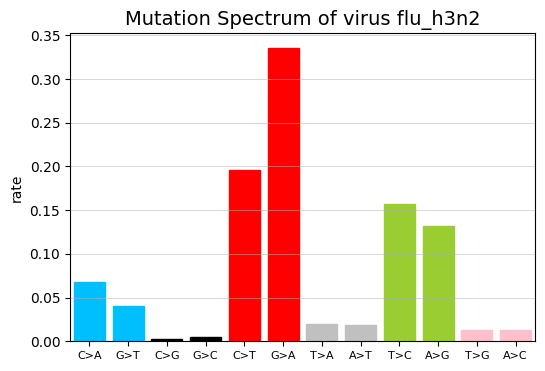

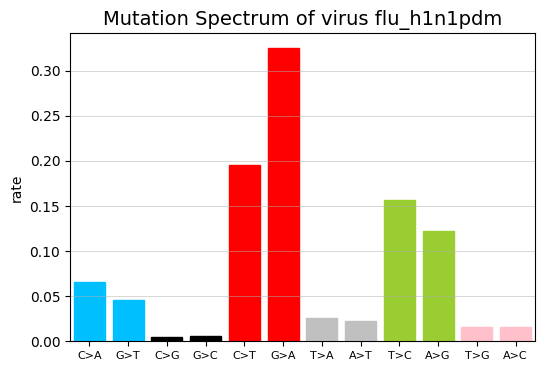

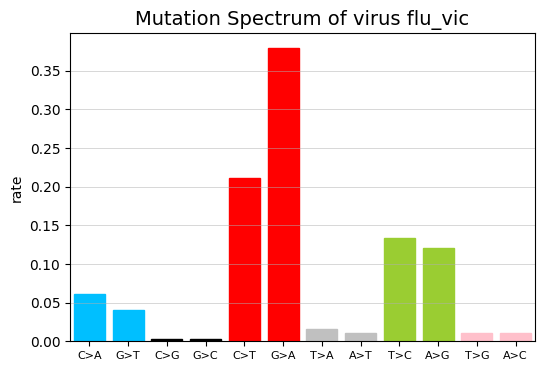

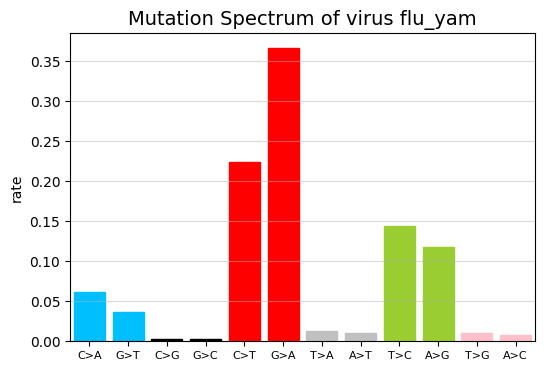

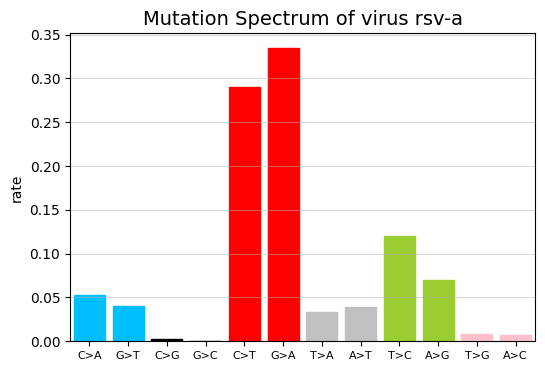

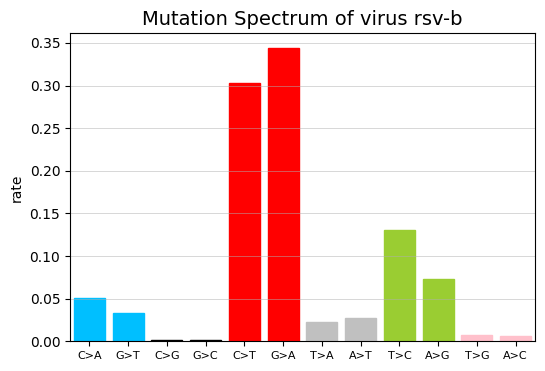

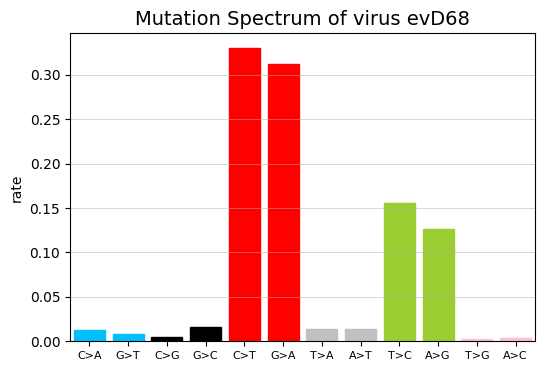

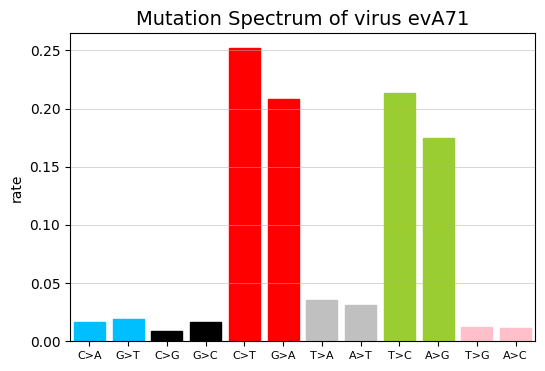

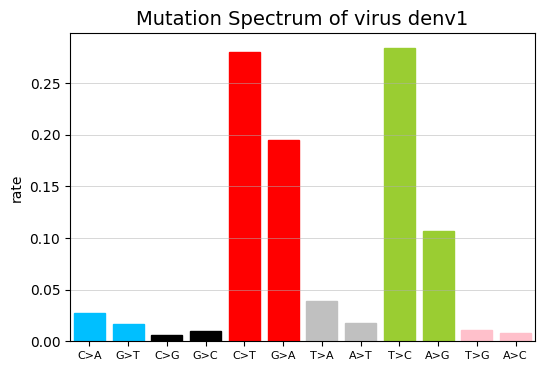

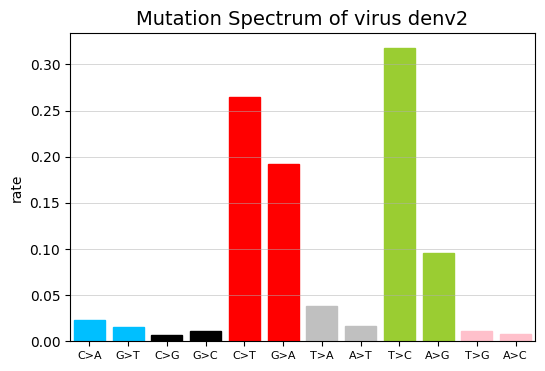

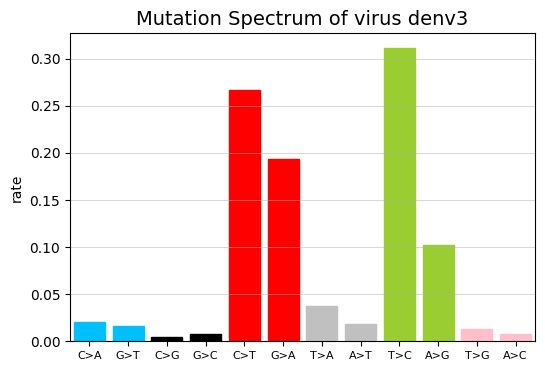

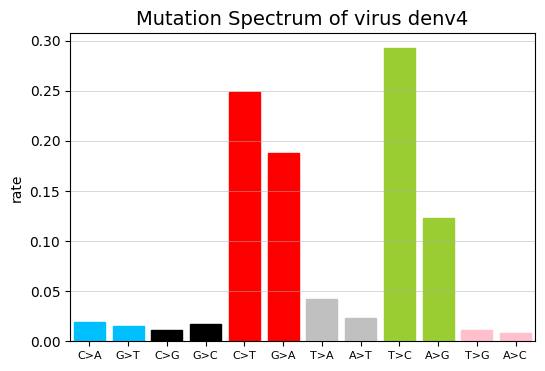

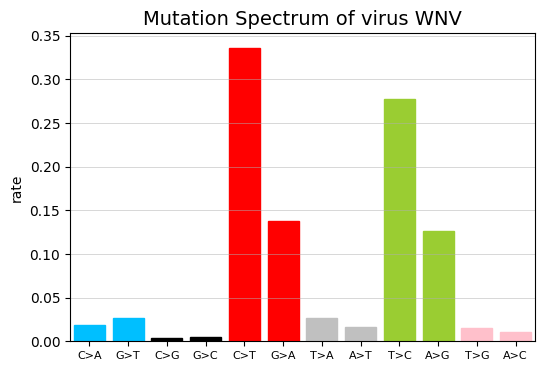

In [12]:
for virus in list(mutspec_data['virus_name'].unique()):
    one_virus_df = mutspec_data[mutspec_data['virus_name']==virus]
    fig = plt.figure(figsize=(6, 4))
    ax = sns.barplot(x="mut_type", y='rate', data=one_virus_df, order=sbs12_ordered, ax=fig.gca())
    ax.grid(axis="y", alpha=.7, linewidth=0.5)
    for bar, clr in zip(ax.patches, colors12):
        bar.set_color(clr)
    ax.set_title('Mutation Spectrum of virus '+virus, fontsize=14)
    ax.set_xlabel("")
    plt.xticks(fontsize=8)
    plt.show()
    plt.close()

In [53]:
viruses_specs = pd.read_csv('../data/ms12syn_all_virus.csv')
viruses_type = pd.read_csv('../data/taxid_virus_type.csv')

In [54]:
#694014  693997  

In [55]:
viruses_type['taxid'] = viruses_type['taxid'].apply(str)
viruses_specs['taxid'] = viruses_specs['taxid'].apply(str)

#viruses_specs.loc[viruses_specs['taxid'] == '118655(1933309)','taxid'] = '118655'
#viruses_type.loc[viruses_type['taxid'] == '1933309','taxid'] = '118655'

#viruses_specs.loc[viruses_specs['taxid'] == '54290_1985356','taxid'] = '54290'
#viruses_type.loc[viruses_type['taxid'] == '1985356','taxid'] = '54290'

In [56]:
nemu_specs = viruses_specs.pivot(index='taxid', columns='Mut', values='MutSpec').reset_index()
nemu_specs = nemu_specs.rename_axis(None, axis=1)
nemu_specs = nemu_specs.rename(columns={"taxid": "virus_name"})

In [57]:
clade_df = pd.read_csv('../data/rates_by_clade.csv')
clade_df = clade_df[['clade', 'mut_type', 'rate']]
clade_df['mut_type'] = clade_df['mut_type'].str.replace('to','>')
clade_df = clade_df[clade_df['clade']=='20A']
pca_df = clade_df.pivot(index='clade', columns='mut_type', values='rate').rename_axis(index=None, columns=None)
pca_df.index.name = 'virus_name'
pca_df = pca_df.reset_index()
pca_df['virus_name'] = 'SARS-CoV-2 20A'

columns = list(pca_df.columns)
columns.remove('virus_name')
pca_df['total'] = pca_df[columns].sum(axis=1)
for col in columns:
    pca_df[col] = pca_df[col]/pca_df['total']
pca_df = pca_df.drop('total',axis=1)

In [58]:
virus_mitspec_df = virus_mitspec_df.append(pca_df)
virus_mitspec_df = virus_mitspec_df.append(nemu_specs)

C:\Users\voron\AppData\Local\Temp\ipykernel_80628\4106057926.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(pca_df)
C:\Users\voron\AppData\Local\Temp\ipykernel_80628\4106057926.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(nemu_specs)


In [59]:
#virus_mitspec_df['virus_name'].unique() '694014'  '693997'  'SARS-CoV-2 20A'

In [61]:
virus_mitspec_df

,T>G,C>T,T>C,A>G,G>A,A>T,C>A,T>A,A>C,G>T,C>G,G>C,virus_name,Color,RNAsense
0,0.013431,0.196083,0.157439,0.131938,0.335605,0.018434,0.067506,0.019876,0.013002,0.039958,0.002099,0.004628,flu_h3n2,0.000000,- Rna
1,0.015716,0.194899,0.156519,0.122620,0.325181,0.022171,0.066162,0.025369,0.015630,0.045243,0.004931,0.005561,flu_h1n1pdm,0.022222,- Rna
2,0.010400,0.211020,0.133855,0.120362,0.379445,0.011133,0.060726,0.016327,0.010306,0.040934,0.002884,0.002609,flu_vic,0.044444,- Rna
3,0.010085,0.223910,0.144512,0.117671,0.366943,0.010157,0.062121,0.013412,0.007849,0.036883,0.003053,0.003405,flu_yam,0.066667,- Rna
4,0.008174,0.290197,0.120245,0.070279,0.334728,0.038923,0.053017,0.033842,0.007703,0.040141,0.002418,0.000332,rsv-a,0.088889,- Rna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,0.062886,0.140027,0.178819,0.201497,0.075154,0.099522,0.026744,0.059673,0.059576,0.041188,0.027030,0.027884,54290,NaN,NaN
28,0.021642,0.201359,0.184034,0.197268,0.209025,0.014998,0.047692,0.014495,0.035927,0.068552,0.002264,0.002743,57482,NaN,NaN
29,0.017707,0.309491,0.092693,0.089537,0.185698,0.048924,0.063711,0.023943,0.021283,0.128513,0.002963,0.015537,693997,NaN,NaN
30,0.023746,0.301053,0.084533,0.099801,0.157302,0.072813,0.052344,0.042581,0.019312,0.125390,0.007905,0.013218,694014,NaN,NaN


In [60]:
clade_names = virus_mitspec_df['virus_name']
pca_data_only = virus_mitspec_df.drop('virus_name', axis=1)
model = PCA(n_components=12).fit(pca_data_only)
pca_model = model.transform(pca_data_only)
#pca_model = pca.fit_transform(pca_data_only)
pca_data = pd.DataFrame(pca_model, columns=["pc"+str(i+1) for i in range(len(pca_data_only.columns))])
pca_data1 = pca_data[["pc1","pc2"]].copy()

ValueError: could not convert string to float: '- Rna'

In [ ]:
#categories = np.unique(virus_mitspec_df['virus_name'])
categories = list(virus_mitspec_df['virus_name'].unique())
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))  
virus_mitspec_df["Color"] = virus_mitspec_df['virus_name'].apply(lambda x: colordict[x])

In [ ]:
virus_mitspec_df = virus_mitspec_df.reset_index(drop=True)

In [ ]:
virus_mitspec_df.loc[virus_mitspec_df['virus_name'].isin(['flu_h3n2',
 'flu_h1n1pdm',
 'flu_vic',
 'flu_yam',
 'rsv-a',
 'rsv-b']), "RNAsense"] = '- Rna'
virus_mitspec_df.loc[virus_mitspec_df['virus_name'].isin(['evD68',
 'evA71',
 'denv1',
 'denv2',
 'denv3',
 'denv4',
 'WNV', 'SARS-CoV-2 20A']), "RNAsense"] = '+ Rna'
 #'SARS-CoV-2 20A'

In [34]:
viruses_type = viruses_type.rename(columns={"taxid": "virus_name", "Type" : "RNAsense"})
viruses_type = viruses_type[['virus_name', "RNAsense"]]

In [35]:
virus_mitspec_df = virus_mitspec_df.merge(viruses_type, how='left', on='virus_name')

In [36]:
virus_mitspec_df.loc[virus_mitspec_df['virus_name'].isin(['11320_1', '11320_2', '3052493', '1133363', '3052763']), 'RNAsense_x'] = '- Rna'
virus_mitspec_df.loc[virus_mitspec_df['RNAsense_y'].isin(['+']), "RNAsense_x"] = '+ Rna'
virus_mitspec_df.loc[virus_mitspec_df['RNAsense_y'].isin(['-']), "RNAsense_x"] = '- Rna'
virus_mitspec_df.loc[virus_mitspec_df['RNAsense_y'].isin(['ds']), "RNAsense_x"] = 'ds Rna'
virus_mitspec_df = virus_mitspec_df.rename(columns={"RNAsense_x": "RNAsense"})
virus_mitspec_df = virus_mitspec_df.drop('RNAsense_y', axis=1)

In [37]:
ldngs = model.components_

In [38]:
features = pca_data_only.columns

In [39]:
viruses_specs = pd.read_csv('../data/ms12syn_all_virus.csv')
viruses_type = pd.read_csv('../data/taxid_virus_type.csv')
viruses_aa_freq = pd.read_csv('../data/aminoacid_freq_all_virus.csv')

#viruses_type[viruses_type['Type'] == '-']['taxid'].unique()
viruses_type['taxid'] = viruses_type['taxid'].apply(str)
viruses_aa_freq['taxid'] = viruses_aa_freq['taxid'].apply(str)
viruses_specs['taxid'] = viruses_specs['taxid'].apply(str)

#viruses_specs.loc[viruses_specs['taxid'] == '118655(1933309)','taxid'] = '118655'
#viruses_type.loc[viruses_type['taxid'] == '1933309','taxid'] = '118655'

#viruses_specs.loc[viruses_specs['taxid'] == '54290_1985356','taxid'] = '54290'
#viruses_type.loc[viruses_type['taxid'] == '1985356','taxid'] = '54290'

viruses_type = viruses_type.rename(columns={"taxid": "virus_name", "Type" : "RNAsense"})
viruses_type = viruses_type[['virus_name', "RNAsense"]]

viruses_specs = viruses_specs.rename(columns={"taxid": "virus_name"})

viruses_specs['virus_name'] = viruses_specs['virus_name'].apply(str)
viruses_type['virus_name'] = viruses_type['virus_name'].apply(str)
viruses_specs = viruses_specs.merge(viruses_type, how='left', on='virus_name')

viruses_specs.loc[viruses_specs['virus_name'].isin(['11320_1', '11320_2', '3052493', '1133363', '3052763']), 'RNAsense'] = '-'

In [40]:
pca_data1['strand'] = virus_mitspec_df['RNAsense']
pca_data1['virus_name'] = virus_mitspec_df['virus_name']

In [41]:
pca_data1.loc[(pca_data1['pc2'] > 0.1) & (pca_data1['strand'] == '+ Rna'), 'strand'] = 'CoV like'

In [42]:
features

Index(['T>G', 'C>T', 'T>C', 'A>G', 'G>A', 'A>T', 'C>A', 'T>A', 'A>C', 'G>T',
       'C>G', 'G>C', 'Color', 'RNAsense'],
      dtype='object')

In [43]:
viruses_specs = viruses_specs.merge(pca_data1, how='left', on='virus_name')
viruses_specs.loc[viruses_specs['strand'] == 'CoV like', 'RNAsense'] = '+ sars'

In [44]:
viruses_specs

,Mut,ObsNum,ExpNum,MutSpec,MutSpec_q05,MutSpec_median,MutSpec_q95,virus_name,RNAsense,pc1,pc2,strand
0,A>C,222.10000,109.4550,0.109127,0.098138,0.109519,0.118038,10407,ds,0.037457,-0.052616,ds Rna
1,A>G,348.58100,159.7600,0.117342,0.109575,0.117365,0.127528,10407,ds,0.037457,-0.052616,ds Rna
2,A>T,114.44900,83.7826,0.073464,0.061877,0.074088,0.084475,10407,ds,0.037457,-0.052616,ds Rna
3,C>A,172.60900,154.1570,0.060217,0.053061,0.060244,0.065731,10407,ds,0.037457,-0.052616,ds Rna
4,C>G,28.65490,131.8260,0.011690,0.009010,0.012031,0.014995,10407,ds,0.037457,-0.052616,ds Rna
...,...,...,...,...,...,...,...,...,...,...,...,...
379,G>C,2.13421,72.8211,0.003805,0.000000,0.003394,0.007554,77763,ds,-0.028555,0.005420,ds Rna
380,G>T,50.06880,72.8211,0.089263,0.066487,0.086102,0.114044,77763,ds,-0.028555,0.005420,ds Rna
381,T>A,49.02400,198.8740,0.032003,0.025325,0.032111,0.040197,77763,ds,-0.028555,0.005420,ds Rna
382,T>C,478.02300,482.0980,0.128729,0.111404,0.130994,0.142362,77763,ds,-0.028555,0.005420,ds Rna


In [49]:
viruses_specs[viruses_specs['virus_name'].isin(['694014', '693997', 'SARS-CoV-2 20A'])]

,Mut,ObsNum,ExpNum,MutSpec,MutSpec_q05,MutSpec_median,MutSpec_q95,virus_name,RNAsense,pc1,pc2,strand
348,A>C,35.63380,132.4620,0.021283,0.012030,0.021493,0.029052,693997,+,-0.100571,0.072521,+ Rna
349,A>G,205.62800,181.6930,0.089537,0.079319,0.089399,0.101004,693997,+,-0.100571,0.072521,+ Rna
350,A>T,75.33350,121.8210,0.048924,0.041820,0.049334,0.057889,693997,+,-0.100571,0.072521,+ Rna
351,C>A,40.24840,49.9796,0.063711,0.048664,0.064629,0.079603,693997,+,-0.100571,0.072521,+ Rna
352,C>G,1.67064,44.6109,0.002963,0.000000,0.000000,0.004848,693997,+,-0.100571,0.072521,+ Rna
353,C>T,533.90100,136.4810,0.309491,0.287070,0.310548,0.329428,693997,+,-0.100571,0.072521,+ Rna
354,G>A,161.38700,68.7575,0.185698,0.168073,0.185960,0.208643,693997,+,-0.100571,0.072521,+ Rna
355,G>C,6.54031,33.3031,0.015537,0.008436,0.015635,0.022687,693997,+,-0.100571,0.072521,+ Rna
356,G>T,54.09670,33.3031,0.128513,0.107939,0.127229,0.149104,693997,+,-0.100571,0.072521,+ Rna
357,T>A,60.73590,200.6900,0.023943,0.017974,0.022978,0.029197,693997,+,-0.100571,0.072521,+ Rna


In [51]:
pca_data1

,pc1,pc2,strand,virus_name
0,-0.034129,-0.134556,- Rna,flu_h3n2
1,-0.034267,-0.124659,- Rna,flu_h1n1pdm
2,-0.078623,-0.159792,- Rna,flu_vic
3,-0.073258,-0.143984,- Rna,flu_yam
4,-0.122436,-0.077670,- Rna,rsv-a
5,-0.123090,-0.080510,- Rna,rsv-b
6,-0.077479,-0.047632,+ Rna,evD68
7,0.056345,-0.007199,+ Rna,evA71
8,0.063173,0.021816,+ Rna,denv1
9,0.087985,0.017370,+ Rna,denv2


In [33]:
viruses_specs['RNAsense'].unique()

array(['ds', '+ sars', '-', '+'], dtype=object)

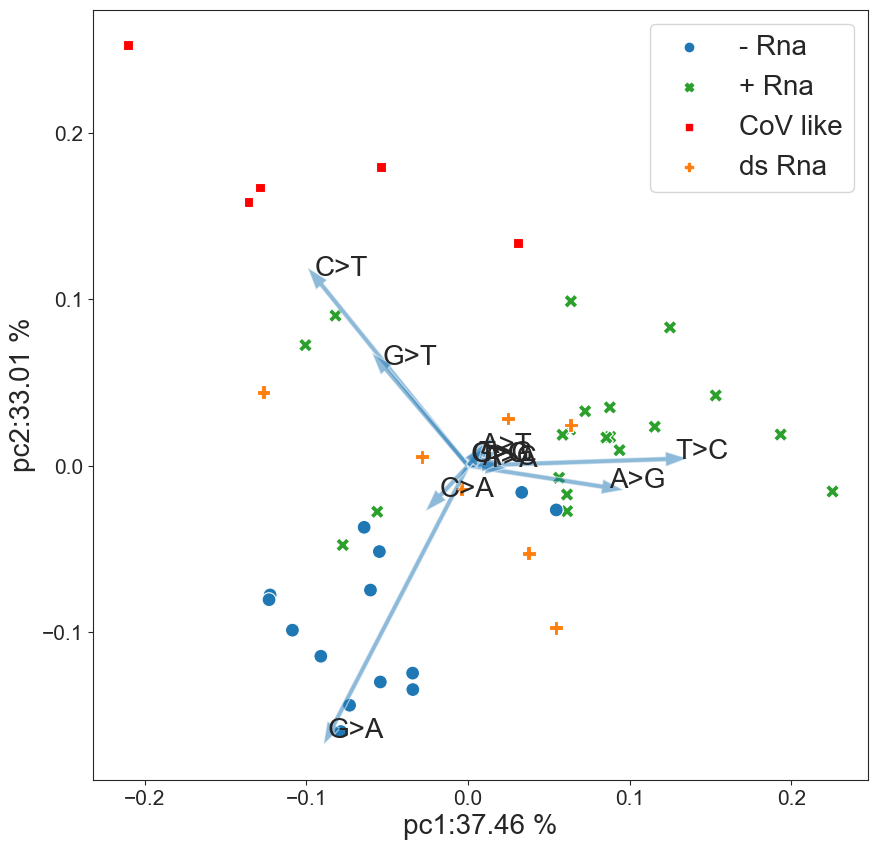

In [56]:
#fig = plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['legend.fontsize'] = 'large'

#heights = [1, 4]
#widths = [1, 1, 1, 1]
sns.set_style("ticks")
#gs = fig.add_gridspec(ncols=3, nrows=2)
#gs = gridspec.GridSpec(2, 4, width_ratios=widths,height_ratios=heights)
#, width_ratios=widths,height_ratios=heights)
#ax1 = fig.add_subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[0, 1])
#ax3 = fig.add_subplot(gs[0, 2])
#ax4 = fig.add_subplot(gs[1, :])
#ax5 = fig.add_subplot(gs[0, 3])

palette = {
    'ds Rna': 'tab:orange',
    '+ Rna': 'tab:green',
    'CoV like': 'red',
    '- Rna' : 'tab:blue'
}
ax4 = sns.scatterplot(data=pca_data1, 
                x="pc1", 
                y="pc2", 
                hue='strand', palette=palette, style='strand', s=100) #hue=virus_mitspec_df['virus_name'],

for i, feature in enumerate(features):
    if ldngs[0, i]/5 > (ldngs[0]/5).mean():
        ax4.arrow(0, 0, ldngs[0, i]/5, 
                 ldngs[1, i]/5, width=0.003, alpha=0.5)
        ax4.text(ldngs[0, i]/5 * 1.05, 
                ldngs[1, i]/5 * 1.05, 
                feature, fontsize=20)
    else:
        ax4.arrow(0, 0, ldngs[0, i]/5, 
                 ldngs[1, i]/5, width=0.003, alpha=0.5)
        ax4.text(ldngs[0, i]/5 * 1.05, 
                ldngs[1, i]/5 * 1.05, 
                feature, fontsize=20)
#ax1.title("PCA visualization of viruses mutation spectrums")
ax4.set_xlabel("pc1:" + "{:.2f}".format(model.explained_variance_ratio_[0] * 100) + " %", fontsize=20)
ax4.set_ylabel("pc2:" + "{:.2f}".format(model.explained_variance_ratio_[1] * 100) + " %", fontsize=20)
ax4.tick_params(axis='y', which='major', labelsize=15)
ax4.tick_params(axis='x', which='major', labelsize=15)

ax4.legend(bbox_to_anchor=(1, 1), fontsize=20)

# for strand in viruses_specs['RNAsense'].unique():
#     strand_data = viruses_specs[viruses_specs['RNAsense'] == strand]
#     sbs12_ordered = ["A>C", "A>G", "A>T", "C>A", "C>G", "C>T", "G>A", "G>C", "G>T", "T>A", "T>C", "T>G"]
#     if strand == '+ sars':
#         color_mapping12 = {
#             "C>A": "darkgreen",
#             "G>T": "darkgreen",
#             "C>G": "darkgreen",
#             "G>C": "darkgreen",
#             "C>T": "darkgreen",
#             "G>A": "darkgreen",
#             "T>A": "darkgreen",
#             "A>T": "darkgreen",
#             "T>C": "darkgreen",
#             "A>G": "darkgreen",
#             "T>G": "darkgreen",
#             "A>C": "darkgreen"}
#         colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]
#         sns.barplot(ax=ax1,x="Mut", y='MutSpec', data=strand_data, order=sbs12_ordered)
#         #ax1.grid(axis="y", alpha=.7, linewidth=0.5)
#         for bar, clr in zip(ax1.patches, colors12):
#             bar.set_color(clr)
#         ax1.set_title('CoV like mean \n mutation spectrum'.format(strand), fontsize=15)
#         ax1.set_xlabel("")
#         ax1.set_ylabel("")
#         ax1.set_ylabel("mut fraction", fontsize=15)
#         ax1.tick_params(axis='x', which='major', rotation=45, labelsize=10)
#         ax1.tick_params(axis='y', which='major', labelsize=15)
#         #ax1.yaxis.set_ticks(np.arange(0, 0.3, 0.05))
#         ax1.set_ylim([0,0.5])
#         #ax1.set_style("whitegrid")
#     elif strand == '+':
#         color_mapping12 = {
#             "C>A": "green",
#             "G>T": "green",
#             "C>G": "green",
#             "G>C": "green",
#             "C>T": "green",
#             "G>A": "green",
#             "T>A": "green",
#             "A>T": "green",
#             "T>C": "green",
#             "A>G": "green",
#             "T>G": "green",
#             "A>C": "green"}
#         colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]
#         sns.barplot(ax=ax2,x="Mut", y='MutSpec', data=strand_data, order=sbs12_ordered)
#         #ax1.grid(axis="y", alpha=.7, linewidth=0.5)
#         for bar, clr in zip(ax2.patches, colors12):
#             bar.set_color(clr)
#         ax2.set_title('+ mean \n mutation spectrum'.format(strand), fontsize=15)
#         ax2.set_xlabel("")
#         ax2.set_ylabel("")
#         ax2.set_ylabel("")
#         ax2.tick_params(axis='x', which='major', rotation=45, labelsize=10)
#         #ax1.yaxis.set_ticks(np.arange(0, 0.3, 0.05))
#         ax2.set_ylim([0,0.5])
#         ax2.yaxis.set_ticks([])
#         #ax1.set_style("whitegrid")
        
#     elif strand == '-':
#         color_mapping12 = {
#             "C>A": "blue",
#             "G>T": "blue",
#             "C>G": "blue",
#             "G>C": "blue",
#             "C>T": "blue",
#             "G>A": "blue",
#             "T>A": "blue",
#             "A>T": "blue",
#             "T>C": "blue",
#             "A>G": "blue",
#             "T>G": "blue",
#             "A>C": "blue"}
#         colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]
#         sns.barplot(ax=ax5,x="Mut", y='MutSpec', data=strand_data, order=sbs12_ordered)
#         #ax3.grid(axis="y", alpha=.7, linewidth=0.5)
#         for bar, clr in zip(ax5.patches, colors12):
#             bar.set_color(clr)
#         ax5.set_title('{} mean \n mutation spectrum'.format(strand), fontsize=15)
#         ax5.set_xlabel("")
#         ax5.set_ylabel("")
#         #ax3.set_ylabel("mut fraction")
#         ax5.tick_params(axis='x', which='major', rotation=45, labelsize=10)
#         #ax3.yaxis.set_ticks(np.arange(0, 0.3, 0.05))
#         ax5.set_ylim([0,0.5])
#         ax5.yaxis.set_ticks([])
#     elif strand == 'ds':
#         color_mapping12 = {
#             "C>A": "orange",
#             "G>T": "orange",
#             "C>G": "orange",
#             "G>C": "orange",
#             "C>T": "orange",
#             "G>A": "orange",
#             "T>A": "orange",
#             "A>T": "orange",
#             "T>C": "orange",
#             "A>G": "orange",
#             "T>G": "orange",
#             "A>C": "orange"}
#         colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]
#         sns.barplot(ax=ax3,x="Mut", y='MutSpec', data=strand_data, order=sbs12_ordered)
#         ax3.grid(axis="y", alpha=.7, linewidth=0.5)
#         for bar, clr in zip(ax3.patches, colors12):
#             bar.set_color(clr)
#         ax3.set_title('{} mean \n mutation spectrum'.format(strand), fontsize=15)
#         ax3.set_xlabel("")
#         ax3.set_ylabel("")
#         #ax2.set_ylabel("mut fraction")
#         ax3.tick_params(axis='x', which='major', rotation=45, labelsize=10)
#         #ax2.yaxis.set_ticks(np.arange(0, 0.3, 0.05))
#         ax3.set_ylim([0,0.5])
#         ax3.yaxis.set_ticks([])

#plt.subplots_adjust(wspace=0, hspace=0.069)
#plt.show()
plt.savefig('../figures/mutspecs_pca.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [86]:
pca_data1

,pc1,pc2,strand,virus_name
0,-0.034129,-0.134556,- Rna,flu_h3n2
1,-0.034267,-0.124659,- Rna,flu_h1n1pdm
2,-0.078623,-0.159792,- Rna,flu_vic
3,-0.073258,-0.143984,- Rna,flu_yam
4,-0.122436,-0.077670,- Rna,rsv-a
5,-0.123090,-0.080510,- Rna,rsv-b
6,-0.077479,-0.047632,+ Rna,evD68
7,0.056345,-0.007199,+ Rna,evA71
8,0.063173,0.021816,+ Rna,denv1
9,0.087985,0.017370,+ Rna,denv2


In [103]:
pca_data1[(pca_data1['pc1']>0) & (pca_data1['strand']=='+ Rna')]

,pc1,pc2,strand,virus_name
6,0.078563,0.012816,+ Rna,evD68
27,0.049675,0.011552,+ Rna,138951


In [107]:
outliers = pca_data1[(pca_data1['pc1']<0) & (pca_data1['strand']=='- Rna') | 
                     (pca_data1['pc1']>0) & (pca_data1['strand']=='+ Rna')]['virus_name'].to_list()

In [108]:
outliers

['evD68', '138951', '3052763', '57482']

In [109]:
with open("../data_obtain/outliers.txt", 'w') as f:
    for o in outliers:
        f.write(str(o) + '\n')

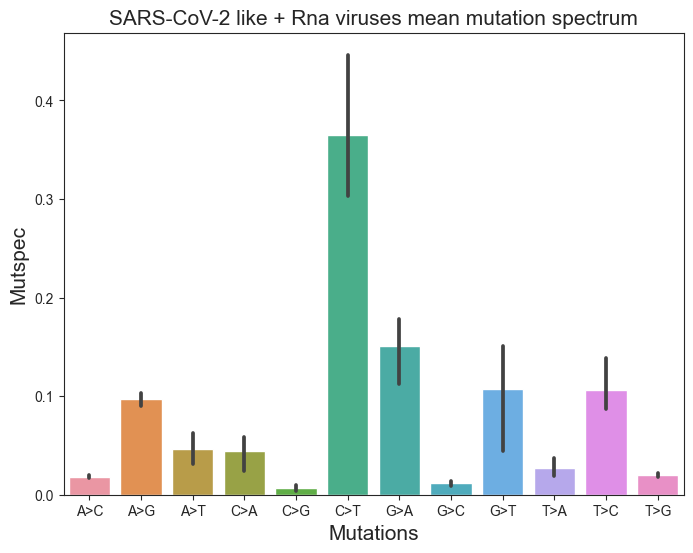

In [64]:
strand_data_sars = viruses_specs[viruses_specs['RNAsense'] == '+ sars']
sbs12_ordered = ["A>C", "A>G", "A>T", "C>A", "C>G", "C>T", "G>A", "G>C", "G>T", "T>A", "T>C", "T>G"]
color_mapping12 = {
            "C>A": "green",
            "G>T": "green",
            "C>G": "green",
            "G>C": "green",
            "C>T": "green",
            "G>A": "green",
            "T>A": "green",
            "A>T": "green",
            "T>C": "green",
            "A>G": "green",
            "T>G": "green",
            "A>C": "green"}
colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]
fig = plt.figure(figsize = (8,6))
sns.barplot(x="Mut", y='MutSpec', data=strand_data_sars, order=sbs12_ordered)
        #ax1.grid(axis="y", alpha=.7, linewidth=0.5)
for bar, clr in zip(ax1.patches, colors12):
    bar.set_color(clr)
plt.title('SARS-CoV-2 like + Rna viruses mean mutation spectrum', fontsize=15)
plt.xlabel("Mutations", fontsize=15)
plt.ylabel("Mutspec", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../figures/mutspecs_pca_sars_like.pdf', bbox_inches='tight')    
plt.show()

In [54]:
strand_data_sars

,Mut,ObsNum,ExpNum,MutSpec,MutSpec_q05,MutSpec_median,MutSpec_q95,virus_name,RNAsense,pc1,pc2,strand
204,A>C,124.32900,429.2170,0.016127,0.014148,0.015936,0.018161,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
205,A>G,1406.02000,728.9790,0.107380,0.102094,0.107407,0.112253,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
206,A>T,227.01300,375.2570,0.033680,0.029394,0.033797,0.037482,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
207,C>A,48.10970,175.3580,0.015274,0.011749,0.014919,0.018971,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
208,C>G,23.68650,115.8630,0.011382,0.006804,0.010770,0.014650,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
209,C>T,2572.76000,291.1060,0.492033,0.480752,0.492587,0.505662,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
210,G>A,1416.32000,478.5530,0.164770,0.156829,0.165122,0.172645,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
211,G>C,30.23200,206.0130,0.008170,0.005504,0.007995,0.010349,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
212,G>T,65.35360,206.0130,0.017661,0.013663,0.017696,0.021360,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like
213,T>A,256.07900,638.2250,0.022338,0.020035,0.021990,0.024661,198112,+ sars,-0.036796,0.186012,+ Rna SARS-CoV-2 like


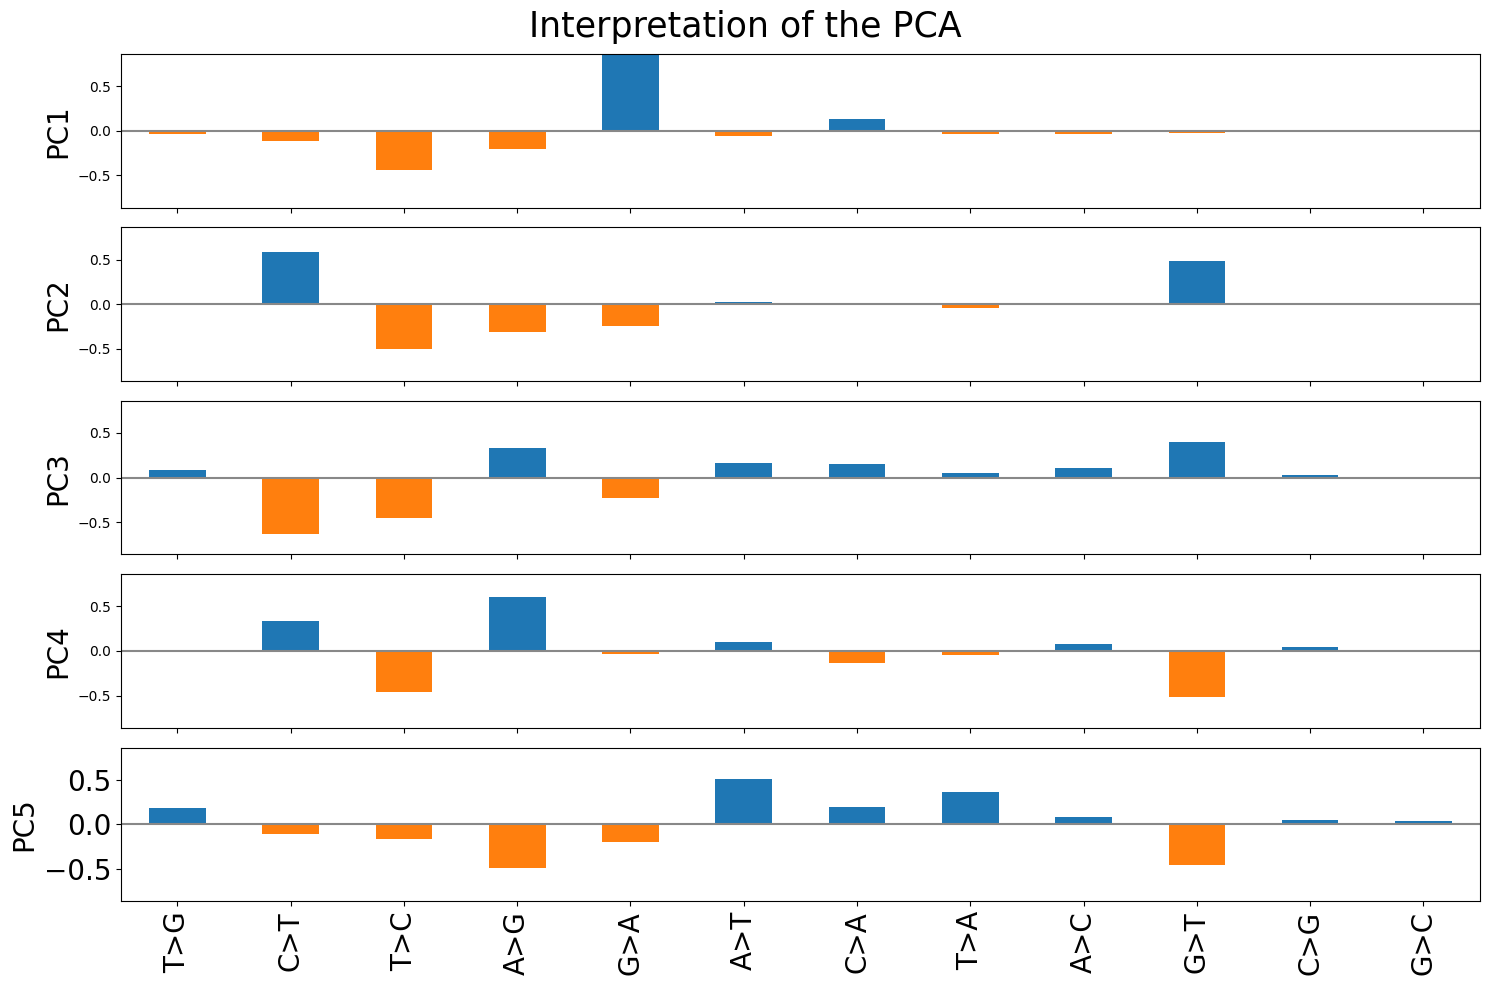

In [20]:
virus_mitspec_df

,T>G,C>T,T>C,A>G,G>A,A>T,C>A,T>A,A>C,G>T,C>G,G>C,virus_name,Color,RNAsense
0,0.013431,0.196083,0.157439,0.131938,0.335605,0.018434,0.067506,0.019876,0.013002,0.039958,0.002099,0.004628,flu_h3n2,0.666667,- Rna
1,0.015716,0.194899,0.156519,0.122620,0.325181,0.022171,0.066162,0.025369,0.015630,0.045243,0.004931,0.005561,flu_h1n1pdm,0.583333,- Rna
2,0.010400,0.211020,0.133855,0.120362,0.379445,0.011133,0.060726,0.016327,0.010306,0.040934,0.002884,0.002609,flu_vic,0.750000,- Rna
3,0.010085,0.223910,0.144512,0.117671,0.366943,0.010157,0.062121,0.013412,0.007849,0.036883,0.003053,0.003405,flu_yam,0.833333,- Rna
4,0.008174,0.290197,0.120245,0.070279,0.334728,0.038923,0.053017,0.033842,0.007703,0.040141,0.002418,0.000332,rsv-a,0.916667,- Rna
5,0.007654,0.302556,0.130986,0.073270,0.344073,0.027371,0.050217,0.022186,0.006557,0.032733,0.001255,0.001142,rsv-b,1.000000,- Rna
6,0.002727,0.330388,0.155263,0.126225,0.312351,0.014119,0.012983,0.013464,0.003692,0.008320,0.004277,0.016191,evD68,0.500000,+ Rna
7,0.012561,0.252110,0.213292,0.174782,0.207964,0.030948,0.016551,0.035659,0.011776,0.018932,0.009032,0.016392,evA71,0.416667,+ Rna
8,0.010890,0.280289,0.283934,0.106834,0.194708,0.017726,0.027413,0.038517,0.007765,0.016525,0.005921,0.009479,denv1,0.083333,+ Rna
9,0.011173,0.264785,0.317783,0.095366,0.191594,0.016655,0.022890,0.038259,0.008255,0.015754,0.006688,0.010799,denv2,0.166667,+ Rna


In [21]:
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

In [22]:
initial_feature_names = list(pca_data_only.columns)

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}


df = pd.DataFrame(dic.items())

# Мутации которые более всего повлияли на компоненты

In [23]:
df

,0,1
0,PC1,G>A
1,PC2,C>T
2,PC3,A>G
3,PC4,G>A
4,PC5,A>T
5,PC6,C>A
6,PC7,G>C
7,PC8,T>A
8,PC9,A>C
9,PC10,T>G


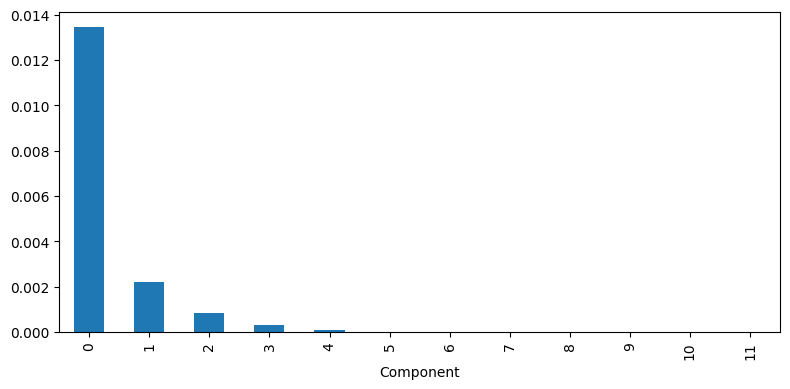

In [24]:
explained_variance = pd.DataFrame(model.explained_variance_)
#showing the first value
ax = explained_variance.plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.show()

In [25]:
pca_data_only.columns

Index(['T>G', 'C>T', 'T>C', 'A>G', 'G>A', 'A>T', 'C>A', 'T>A', 'A>C', 'G>T',
       'C>G', 'G>C'],
      dtype='object')

C:\Users\voron\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


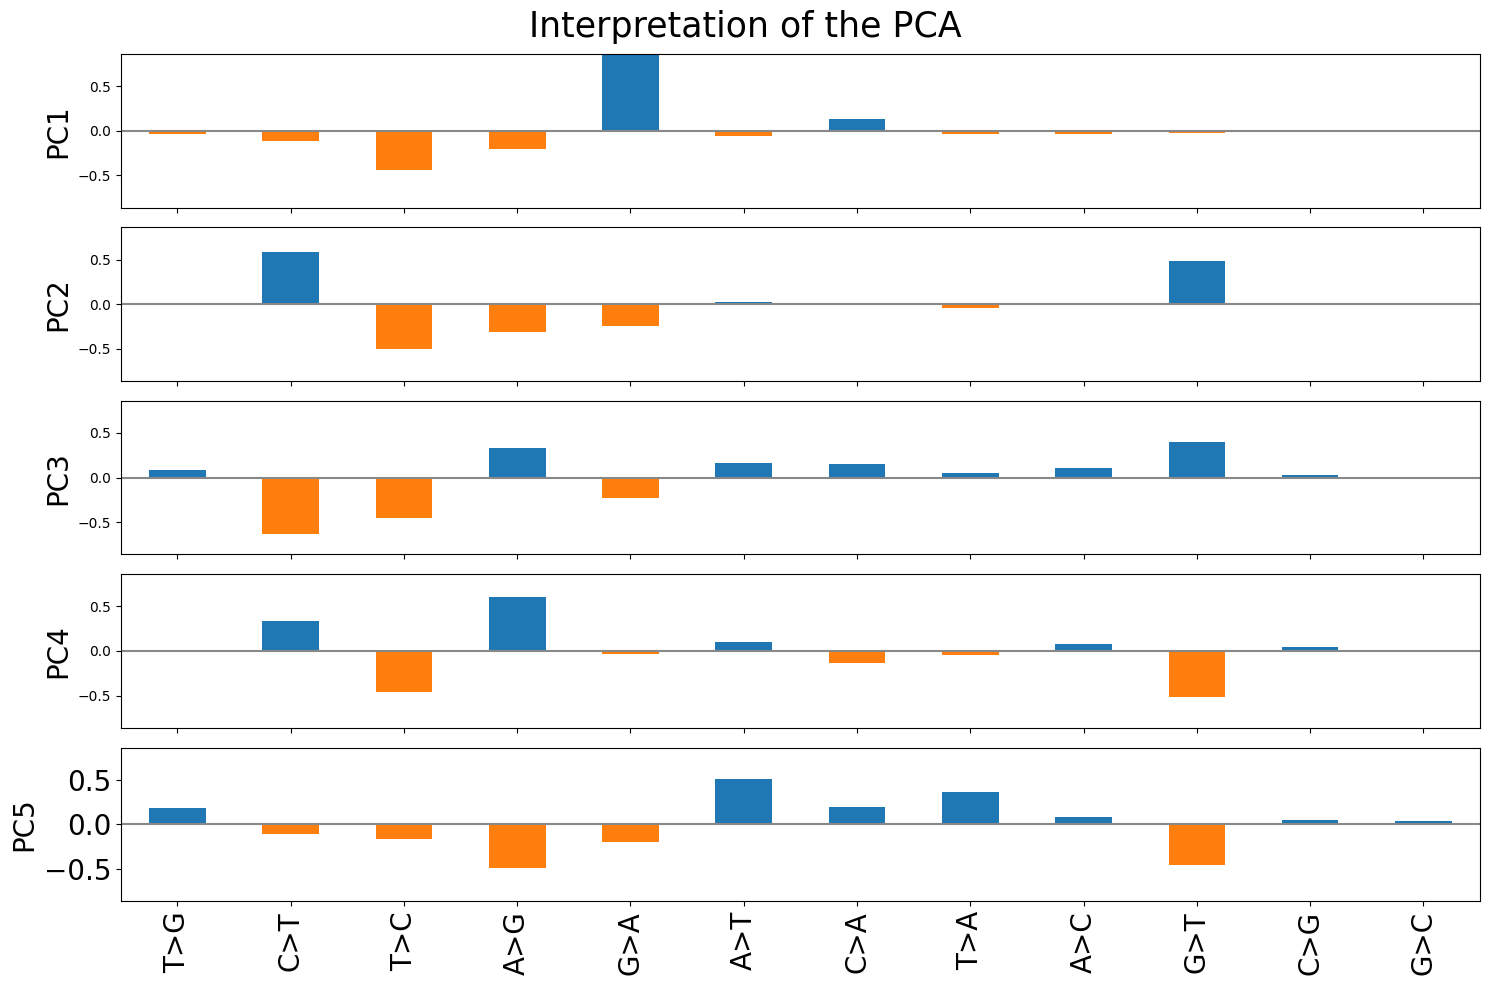

In [167]:
loadings = pd.DataFrame(model.components_[0:5, :], 
                        columns=pca_data_only.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))
f, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}', fontsize=20)
    ax.set_ylim(-maxPC, maxPC)
plt.suptitle('Interpretation of the PCA', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.show()

In [27]:
loadings = pd.DataFrame(model.components_, 
                        columns=pca_data_only.columns)

In [28]:
loadings

,T>G,C>T,T>C,A>G,G>A,A>T,C>A,T>A,A>C,G>T,C>G,G>C
0,0.009837,0.162691,0.644066,0.035801,-0.722266,-0.002503,-0.153979,0.066650,-0.003591,-0.080312,0.014994,0.028611
1,-0.046748,0.904599,-0.296352,-0.232354,-0.034329,0.045975,-0.160250,-0.032528,-0.044409,-0.071745,-0.020686,-0.011172
2,0.012268,0.023052,-0.431439,0.820939,-0.297554,0.018935,-0.179056,-0.072198,0.032689,-0.049883,0.029201,0.093044
3,-0.110150,0.127096,0.407611,0.269387,0.514860,-0.325557,-0.371346,-0.206912,-0.097068,-0.383327,0.018881,0.156525
4,0.119454,0.194656,0.111631,0.158828,-0.038070,-0.513139,0.455472,-0.483113,0.057690,0.338034,-0.144312,-0.257131
5,0.155690,-0.004670,0.110287,0.079303,0.152892,0.132742,-0.590197,0.072617,0.039253,0.529249,-0.177707,-0.499460
6,0.035090,-0.107159,-0.137336,-0.247599,-0.116300,-0.356598,-0.351824,-0.180903,0.133607,0.405781,0.436808,0.486432
7,-0.252371,0.063012,-0.040682,0.107841,0.009272,-0.485849,0.092016,0.663947,-0.328341,0.114903,0.263746,-0.207494
8,-0.163543,0.016109,0.096139,0.072177,0.025714,0.373384,0.083731,-0.337630,-0.732998,0.229547,0.327702,0.009668
9,0.665385,-0.039546,-0.075468,-0.068764,-0.032189,-0.066060,-0.040900,-0.068213,-0.060268,-0.355293,0.514335,-0.373019


In [29]:
loadings.loc[0, :].plot.bar(ax=ax, color=colors)

<Axes: ylabel='PC5'>